In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
from pipeline.utils import timeit
from pipeline.feature_selection import FeatureSelection
from pipeline.modeling import ModelCreator
from pipeline.scoring import ScoringWithLGBM
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(rc={'figure.figsize':(12,9)})

### Отбор признаков

In [2]:
FS = FeatureSelection(
    table_name='uat_dm.dd_333_first_use',
    report_date='2019-06-01',
    data_version=1,
    top_amount=30
)

In [3]:
dt = FS.download_data()
dt = FS.process_data(dt,
    ex_bc=False,
    ex_cl=False
)

Start download_data.
End download_data. Time: 0.74 sec.

Start process_data.
....Start bad_features_postfilter.
....End bad_features_postfilter. Time: 0.33 sec.

....Start wcat_features_fix.
....End wcat_features_fix. Time: 1.82 sec.

....Start cats_fit_transform.
....End cats_fit_transform. Time: 3.49 sec.

....Start cats_fit_transform.
....End cats_fit_transform. Time: 1.10 sec.

End process_data. Time: 6.74 sec.


In [4]:
tables = ['uat_dm.eg_chrgd_final_table', 'uat_dm.eg_be_final_table',
    'uat_dm.eg_scd2_final_table', 'uat_dm.dd_ussd_final_table']

In [5]:
dt = FS.add_ext_features(dt, tables=tables)

Start download_data.
End download_data. Time: 0.16 sec.

Start download_data.
End download_data. Time: 0.13 sec.

Start download_data.
End download_data. Time: 0.09 sec.

Start download_data.
End download_data. Time: 0.05 sec.



Start dmx_check.
....Currently on checking: uat_dm.eg_chrgd_final_table
....Start feature_selection.
........Score before feature selection:
........Max CV ROC AUC score: 0.7663946276041667
........Min CV ROC AUC score: 0.6714011783854167
........Average CV ROC AUC score: 0.7517622196701388



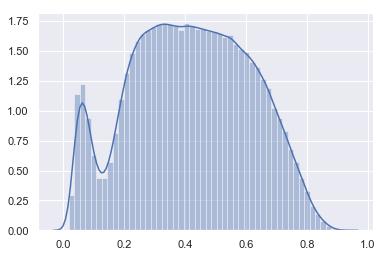

........Score on top 30 selected features:
........Max CV ROC AUC score: 0.7587936080729167
........Min CV ROC AUC score: 0.6867404635416667
........Average CV ROC AUC score: 0.7482831806944443



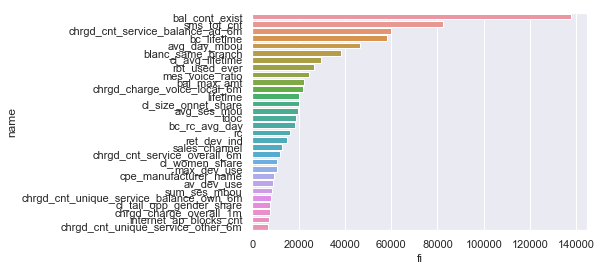

....End feature_selection. Time: 48.24 sec.

....Currently on checking: uat_dm.eg_be_final_table
....Start feature_selection.
........Score before feature selection:
........Max CV ROC AUC score: 0.7619469809027778
........Min CV ROC AUC score: 0.6806990950520835
........Average CV ROC AUC score: 0.7492048473524305



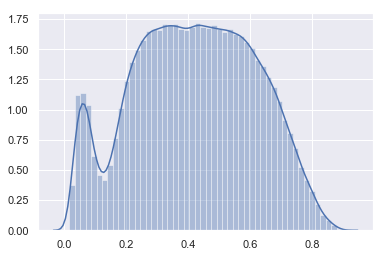

........Score on top 30 selected features:
........Max CV ROC AUC score: 0.7561564331597223
........Min CV ROC AUC score: 0.6920483229166667
........Average CV ROC AUC score: 0.7459667911848956



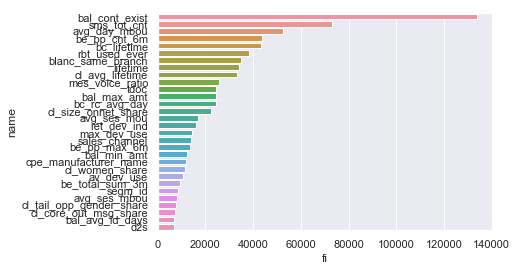

....End feature_selection. Time: 44.00 sec.

....Currently on checking: uat_dm.eg_scd2_final_table
....Start feature_selection.
........Score before feature selection:
........Max CV ROC AUC score: 0.7683959383680555
........Min CV ROC AUC score: 0.6868614930555555
........Average CV ROC AUC score: 0.7549052285546874



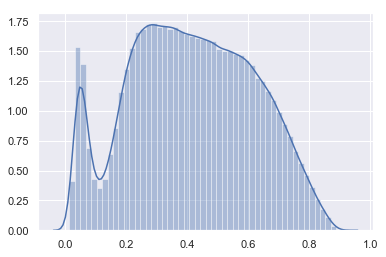

........Score on top 30 selected features:
........Max CV ROC AUC score: 0.7632778229166666
........Min CV ROC AUC score: 0.6997294969618056
........Average CV ROC AUC score: 0.7524410094184028



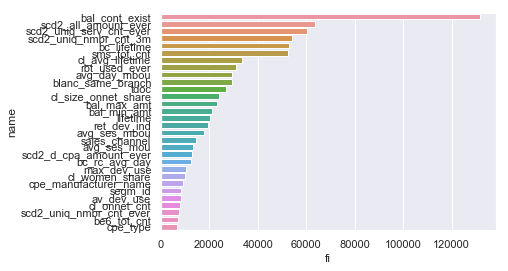

....End feature_selection. Time: 40.57 sec.

....Currently on checking: uat_dm.dd_ussd_final_table
....Start feature_selection.
........Score before feature selection:
........Max CV ROC AUC score: 0.7677492764756944
........Min CV ROC AUC score: 0.6981258923611111
........Average CV ROC AUC score: 0.7537925627170137



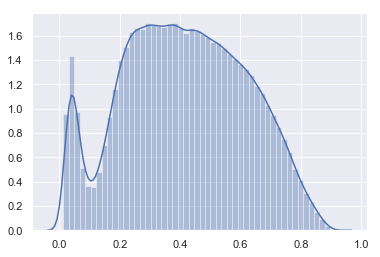

........Score on top 30 selected features:
........Max CV ROC AUC score: 0.7628911032986112
........Min CV ROC AUC score: 0.6974374066840279
........Average CV ROC AUC score: 0.7516452316319446



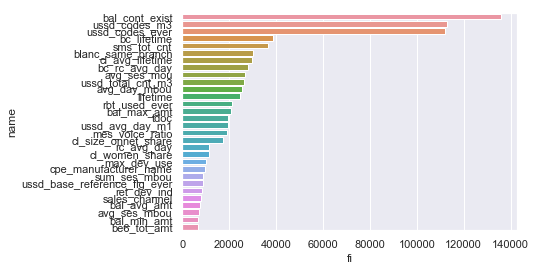

....End feature_selection. Time: 35.10 sec.

End dmx_check. Time: 169.63 sec.


In [6]:
FS.dmx_check(dt,
    tables=tables,
    how='pair',
    perm=False
)

In [7]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
#     'num_leaves': 32,
    'is_unbalance': True,
    'max_depth': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'random_state': 321
}

Start feature_selection.
....Score before feature selection:
....Max CV ROC AUC score: 0.7686130130208333
....Min CV ROC AUC score: 0.6902553124999999
....Average CV ROC AUC score: 0.7534878340234376



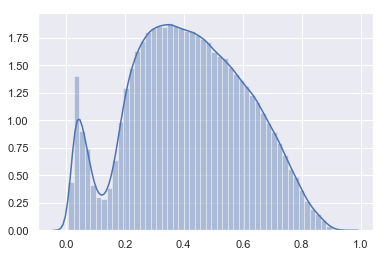

....Score on top 30 selected features:
....Max CV ROC AUC score: 0.7641773953993056
....Min CV ROC AUC score: 0.6906065182291666
....Average CV ROC AUC score: 0.7515247104687497



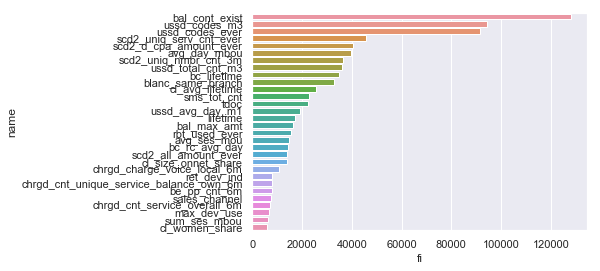

End feature_selection. Time: 28.79 sec.



In [8]:
res = FS.feature_selection(dt,
    params=params,
    perm=False,
    use_ext=True
)

In [9]:
FS.save_top(30)
FS.save_ext()


Top features saved to file.
External features saved to file.


### Построение модели с валидацией по дополнительному дата сету val_1

In [10]:
MC = ModelCreator(
    table_name='uat_dm.dd_333_first_use',
    report_date='2019-06-01',
    data_version=1)


In [11]:
dt = MC.download_data()
dt = MC.add_ext_features(dt)


Start download_data.
End download_data. Time: 0.72 sec.

Start download_data.
End download_data. Time: 0.05 sec.

Start download_data.
End download_data. Time: 0.16 sec.

Start download_data.
End download_data. Time: 0.13 sec.

Start download_data.
End download_data. Time: 0.09 sec.



In [12]:
sub_query = """
    SELECT subs_id, label
    from uat_dm.dd_333_camp_070619
    """
dt_val_1 = MC.download_data('prd2_mds_v.dmsc', sub_query, 'val_1')
dt_val_1 = MC.add_ext_features(dt_val_1, sub_query, 'val_1')

Start download_data.
File data_v1/val_1_2019-06-01_dmsc.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.97 sec.

End download_data. Time: 112.98 sec.
Start download_data.
File data_v1/val_1_2019-06-01_dd_ussd_final_table.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.33 sec.

End download_data. Time: 10.77 sec.
Start download_data.
File data_v1/val_1_2019-06-01_eg_chrgd_final_table.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.40 sec.

End download_data. Time: 52.71 sec.
Start download_data.
File data_v1/val_1_2019-06-01_eg_be_final_table.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.43 sec.

End download_data. Time: 66.04 sec.
Start download_data.
File data_v1/val_1_2019-06-01_eg_scd2_final_table.feather not found and will b

In [13]:
dt_train, dt_val_0 = MC.split(dt)
dt_list = [dt_train, dt_val_0, dt_val_1]

Start split.
End split. Time: 0.21 sec.



In [14]:
MC.process_dt_list(dt_list)

Start wcat_features_fix.
End wcat_features_fix. Time: 0.00 sec.

Start cats_fit_transform.
End cats_fit_transform. Time: 0.56 sec.

Start wcat_features_fix.
End wcat_features_fix. Time: 0.00 sec.

Start cats_transform.
End cats_transform. Time: 0.39 sec.

Start wcat_features_fix.
End wcat_features_fix. Time: 0.00 sec.

Start cats_transform.
End cats_transform. Time: 0.20 sec.



In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'max_depth': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'verbose': 1,
    'random_state': 321
}

Start model_create.
[1]	valid_0's auc: 0.691015	valid_1's auc: 0.684491	valid_2's auc: 0.632232
[2]	valid_0's auc: 0.711741	valid_1's auc: 0.706255	valid_2's auc: 0.645575
[3]	valid_0's auc: 0.724695	valid_1's auc: 0.720109	valid_2's auc: 0.658252
[4]	valid_0's auc: 0.727956	valid_1's auc: 0.723161	valid_2's auc: 0.660076
[5]	valid_0's auc: 0.730819	valid_1's auc: 0.725575	valid_2's auc: 0.660312
[6]	valid_0's auc: 0.733571	valid_1's auc: 0.727887	valid_2's auc: 0.663288
[7]	valid_0's auc: 0.734464	valid_1's auc: 0.728618	valid_2's auc: 0.665646
[8]	valid_0's auc: 0.737531	valid_1's auc: 0.731956	valid_2's auc: 0.665205
[9]	valid_0's auc: 0.73849	valid_1's auc: 0.733555	valid_2's auc: 0.666067
[10]	valid_0's auc: 0.739441	valid_1's auc: 0.734644	valid_2's auc: 0.667066
[11]	valid_0's auc: 0.741	valid_1's auc: 0.736058	valid_2's auc: 0.664585
[12]	valid_0's auc: 0.741906	valid_1's auc: 0.736575	valid_2's auc: 0.667177
[13]	valid_0's auc: 0.743383	valid_1's auc: 0.737677	valid_2's auc: 0

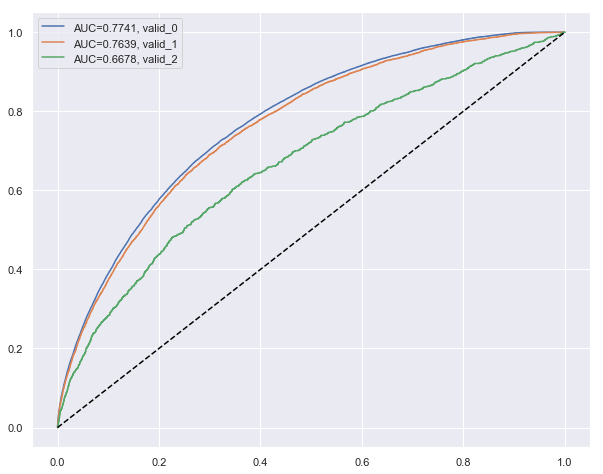

End model_create. Time: 5.65 sec.



In [16]:
lgb_model = MC.model_create(dt_train, dt_list, params=params)

Start model_evaluate.


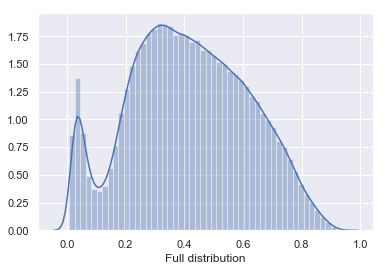

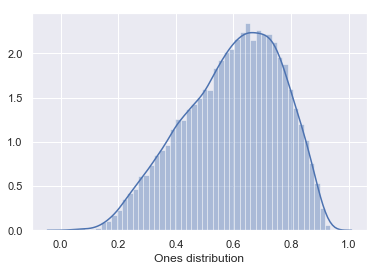

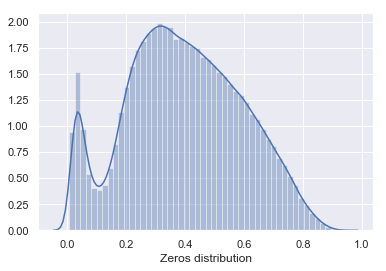

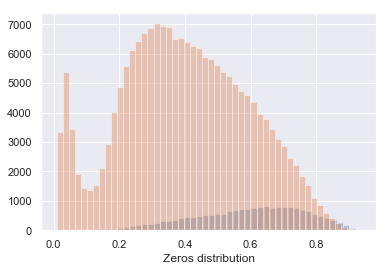

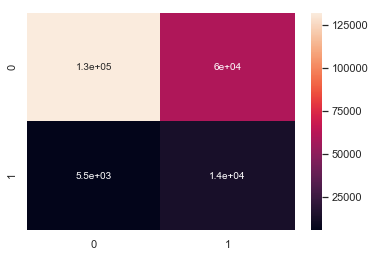

Accuracy score: 0.6897111742424242

              precision    recall  f1-score   support

       Zeros       0.96      0.69      0.80    191973
        Ones       0.19      0.72      0.30     19227

   micro avg       0.69      0.69      0.69    211200
   macro avg       0.57      0.70      0.55    211200
weighted avg       0.89      0.69      0.76    211200

Total positive labels: 19227. Positive labels predicted: 73848

Average precision-recall score: 0.28


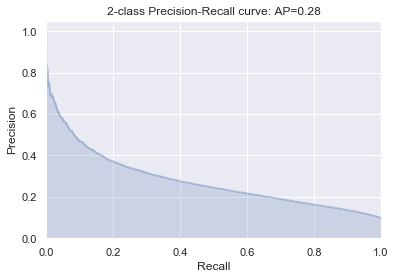

End model_evaluate. Time: 2.72 sec.



In [17]:
MC.model_evaluate(dt_train, prob=0.5)

In [18]:
MC.model_save()
MC.cat_dict_save()

Model successfully saved as model.lgb
Categories dictionary successfully saved as cat_dict.npy


### Загрузка данных для скоринга и adversarial validation

In [19]:
SC = ScoringWithLGBM(
    data_version=1,
    ext_date='2019-06-01',
    dmsc_date='2019-06-01',
    load_table='uat_dm.dd_333_temp_test'
)

In [20]:
sub_query = """
select * from uat_dm.dd_333_subs_sample
"""
dt_score = SC.download_data(sub_query=sub_query)
dt_score = SC.add_ext_features(dt_score, sub_query=sub_query)

Start download_data.
File data_v1/to_score_2019-06-01_dmsc.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.36 sec.

End download_data. Time: 33.80 sec.
Start download_data.
File data_v1/to_score_2019-06-01_dd_ussd_final_table.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.44 sec.

End download_data. Time: 15.42 sec.
Start download_data.
File data_v1/to_score_2019-06-01_eg_chrgd_final_table.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.38 sec.

End download_data. Time: 15.52 sec.
Start download_data.
File data_v1/to_score_2019-06-01_eg_be_final_table.feather not found and will be downloaded
 
....Start establish_connection.
....End establish_connection. Time: 1.46 sec.

End download_data. Time: 12.40 sec.
Start download_data.
File data_v1/to_score_2019-06-01_eg_scd2_final_table.feather not fo

In [23]:
dt_score = SC.process_data(dt_score)
dt = SC.process_data(dt)

Start process_data.
....Start wcat_features_fix.
....End wcat_features_fix. Time: 0.00 sec.

....Start cats_transform.
....End cats_transform. Time: 0.47 sec.

End process_data. Time: 0.47 sec.
Start process_data.
....Start wcat_features_fix.
....End wcat_features_fix. Time: 0.00 sec.

....Start cats_transform.
....End cats_transform. Time: 0.15 sec.

End process_data. Time: 0.15 sec.


Start adversarial_validation.
....Start split.
....End split. Time: 0.39 sec.

....Start model_create.
[1]	valid_0's auc: 0.514818	valid_1's auc: 0.511165
[2]	valid_0's auc: 0.517754	valid_1's auc: 0.513606
[3]	valid_0's auc: 0.518429	valid_1's auc: 0.51449
[4]	valid_0's auc: 0.519105	valid_1's auc: 0.514491
[5]	valid_0's auc: 0.51957	valid_1's auc: 0.515037
[6]	valid_0's auc: 0.519999	valid_1's auc: 0.514988
[7]	valid_0's auc: 0.52032	valid_1's auc: 0.514998
[8]	valid_0's auc: 0.520625	valid_1's auc: 0.515111
[9]	valid_0's auc: 0.520784	valid_1's auc: 0.515093
[10]	valid_0's auc: 0.521242	valid_1's auc: 0.515105
[11]	valid_0's auc: 0.521384	valid_1's auc: 0.515369
[12]	valid_0's auc: 0.521729	valid_1's auc: 0.515346
[13]	valid_0's auc: 0.52211	valid_1's auc: 0.515654
[14]	valid_0's auc: 0.522309	valid_1's auc: 0.516058
[15]	valid_0's auc: 0.522428	valid_1's auc: 0.515899
[16]	valid_0's auc: 0.522677	valid_1's auc: 0.516155
[17]	valid_0's auc: 0.523102	valid_1's auc: 0.516268
[18]	vali

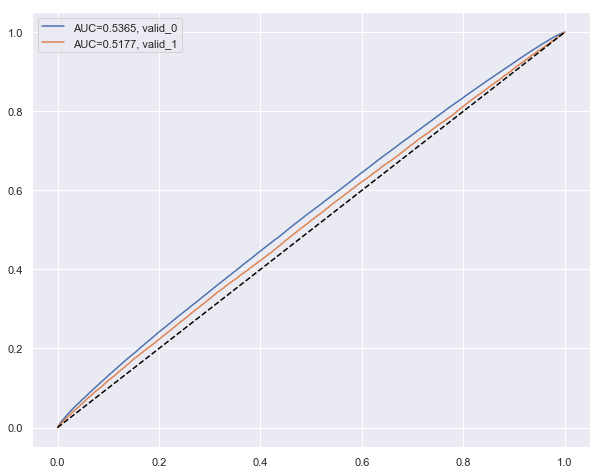

....End model_create. Time: 11.41 sec.



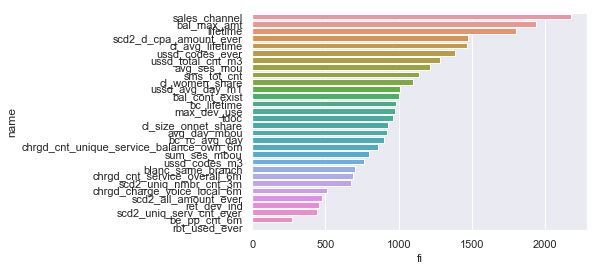

End adversarial_validation. Time: 12.55 sec.


In [26]:
MC.adversarial_validation(dt, dt_score, zeros_part=1.)

### Adversarial показывает хороший результат, так что дроп признаков и обновление модели не требуется

In [28]:
# lgb_model = MC.model_create(dt_train, dt_list,
#     drop_list=['bal_cont_exist'])

# MC.model_evaluate(dt, prob=0.5)

# MC.model_save()
# MC.cat_dict_save()

# SC.reinit()

### Скорим и заливаем

Start score_data.


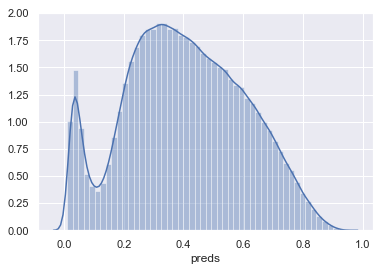

End score_data. Time: 1.92 sec.



In [27]:
dt_score = SC.score_data(dt_score)

In [0]:
SC.upload_data(dt_score)